In [1]:
import autograd.numpy as np
from autograd import grad
from scipy import optimize
import matplotlib.pyplot as plt


### Import Data

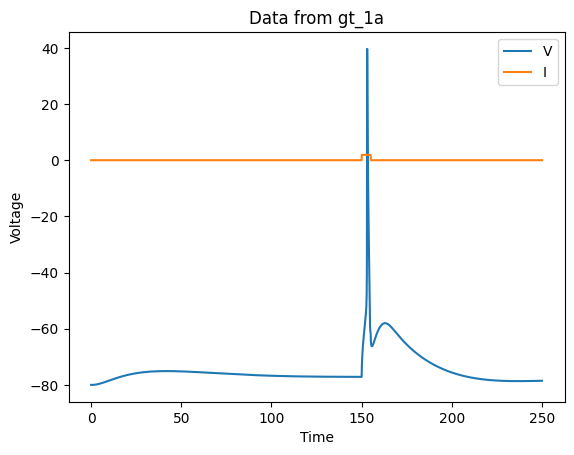

In [2]:
import zipfile
import csv

fname = 'gt_1a' # user defined filename

with zipfile.ZipFile('./sim_data/' + fname + '.zip', 'r') as zip_ref:
    zip_ref.extractall()
    
with open(fname + '.csv', newline='') as csvfile:
    data = list(csv.reader(csvfile))
    
data_steps = [row[0] for row in data][1:-1] # extract time data
data_steps = np.array([float(i) for i in data_steps]) # convert to numpy array of floats

V_data = [row[1] for row in data][1:-1]
V_data = np.array([float(i) for i in V_data])

I_data = [row[2] for row in data][1:-1]
I_data = np.array([float(i) for i in I_data])


plt.plot(data_steps, V_data, label = 'V')
plt.plot(data_steps, I_data, label = 'I')
plt.xlabel('Time')
plt.ylabel ('Voltage')
plt.title('Data from ' + fname)
plt.legend()

In [3]:
# determine center of impulse

impulse = np.where(I_data != 0.0)
center = round((impulse[0][-1] - impulse[0][0])/2) + impulse[0][0]
b = data_steps[center]
# b = 150 # for no ap dataset 
b

152.525

In [4]:
# we could use these values as initial guesses if we wanted, but that might not be 
# super interesting to see the full power of the adjoint

# a = np.max(I_data)
# c = np.shape(impulse)[1]*dt


### Define Forward Model

In [14]:
### Define all parameters ###

# Define HH model parameters
g_Na = 120.0  # Sodium conductance (mS/cm^2)
g_K = 36.0   # Potassium conductance (mS/cm^2)
g_L = 0.3    # Leak conductance (mS/cm^2)
E_Na = 50.0  # Sodium reversal potential (mV)
E_K = -77.0  # Potassium reversal potential (mV)
E_L = -55.0  # Leak reversal potential (mV)
C_m = 1.0    # Membrane capacitance (uF/cm^2)

# Define time parameters
dt = 0.025
t = np.arange(0, 250, dt)


# Initialize state variables
V0 = -80.0 #V_data[0]  # Membrane voltage (mV)
m, h, n = 0.05, 0.6, 0.32  # Initial values of gating variables

In [15]:
# Define the HH model equations
def alpha_m(V):
    '''transition rate constant for m-gates (rapid response Na) shut gates opening as a function of voltage'''
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):
    '''transition rate constant for m-gates (rapid response Na) open gates closing as a function of voltage '''
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V):
    '''transition rate constant for h-gates (slow response Na) shut gates opening as a function of voltage'''
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    '''transition rate constant for h-gates (slow response Na) open gates closing as a function of voltage '''
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

def alpha_n(V):
     '''transition rate constant for n-gates (slow response K) shut gates opening as a function of voltage'''
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

def beta_n(V):
    '''transition rate constant for n-gates (slow response K) open gates closing as a function of voltage '''
    return 0.125 * np.exp(-(V + 65) / 80.0)


# Define the HH model differential equations
def hodgkin_huxley_eq(V, m, h, n, I_params, t):
    '''full hodgkin huxley model
    
    Args: 
        V
    Returns: 
    '''
    #I = I_params[0]*np.sin(I_params[1]*t)
    I = I_params[0]*np.exp(-(t-b)**2/(2*I_params[1]**2))
    dVdt = (I - g_Na * m**3 * h * (V - E_Na) - g_K * n**4 * (V - E_K) - g_L * (V - E_L)) / C_m
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    return dVdt, dmdt, dhdt, dndt


# Forward Euler to solve IVP
def integrate_HH(V0, m, h, n, I_params, dt, t):
    '''forward euler method to solve Hodgkin Huxley
    
    Args: 
        V0
        m
        h
        n 
        I_params
        dt 
        t
    Returns: 
        V_record (array): record of voltages for each time step
    '''
    V_record = np.zeros_like(t)
    V = V0
    
    for i in range(len(t)):
        V_record[i] = V
        dVdt, dmdt, dhdt, dndt = hodgkin_huxley_eq(V, m, h, n, I_params, t[i])
        V += dVdt * dt
        m += dmdt * dt
        h += dhdt * dt
        n += dndt * dt
    return V_record

In [16]:
# test run forward model

# a = 5.0
# c = 2.0

# I_params = np.array([a, c])

# V_record = integrate_HH(V0, m, h, n, I_params, dt, t)
# I_stimulus = I_params[0]*np.exp(-(t-b)**2/(2*I_params[1]**2))

# plt.plot(t, V_record, label = 'V')
# plt.plot(t, I_stimulus, label = 'I')
# plt.xlabel('time')
# plt.legend()

### Define Cost Function

In [17]:
def forward_model_cost(I_params, V0, m, h, n, dt, t, data_steps, V_data):

    cost = 0
        
    V_record = []
    V = V0
    
    for i in range(len(t)):
        
        # forward euler solver 
        V_record.append(V)
        
        dVdt, dmdt, dhdt, dndt = hodgkin_huxley_eq(V, m, h, n, I_params, t[i])
        V += dVdt * dt
        m += dmdt * dt
        h += dhdt * dt
        n += dndt * dt

        # compute cost at time t_i
        if t[i] in data_steps:
            j = np.where(data_steps == t[i])
            cost += (V_record[i] - V_data[j])**2 
                  
    cost = cost/len(data_steps)

    return cost
     

In [18]:
# test and look at total cost before any optimization

a = 5.0
c = 2.0

I_params = np.array([a, c])

total_cost = forward_model_cost(I_params, V0, m, h, n, dt, t, data_steps, V_data)
total_cost  

array([96.85022681])

### Compute Gradient

In [19]:
# find AD representation of gradient using autograd
# autograd syntax: grad(f, 0) = gradient of f w.r.t. 0th argument of f
grad_AD = grad(forward_model_cost, 0) 

# test/compute gradient at specific point
# grad_AD(I_params, V0, m, h, n, dt, t, data_steps, V_data)


step size= 1.0 , example gradient finite difference error= [905.41368327]
step size= 0.1 , example gradient finite difference error= [92.45856673]
step size= 0.01 , example gradient finite difference error= [552.95083487]
step size= 0.001 , example gradient finite difference error= [4.25764331]
step size= 0.0001 , example gradient finite difference error= [0.16356186]
step size= 1e-05 , example gradient finite difference error= [0.01460906]
step size= 1e-06 , example gradient finite difference error= [0.00146065]
step size= 1e-07 , example gradient finite difference error= [0.0001459]
step size= 1e-08 , example gradient finite difference error= [1.45892147e-05]
step size= 1e-09 , example gradient finite difference error= [1.48024727e-06]
step size= 1e-10 , example gradient finite difference error= [1.5110349e-07]
step size= 1e-11 , example gradient finite difference error= [5.37673634e-06]
step size= 1e-12 , example gradient finite difference error= [2.9042004e-05]
step size= 1e-13 , e

Text(0, 0.5, 'error')

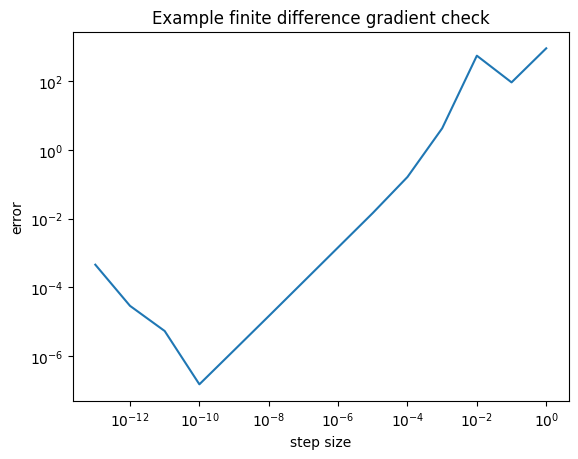

In [20]:
# TO-DO: CLEAN THIS UP

# def set_I_params(val, idx):
    
#     if idx = 0:
#         I_

### FD check wrt a ####

# step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]
# p = np.random.randint(0,5000)

# # Make log-log plot of gradient finite difference error vs. step size

# w = c
# A1 = np.random.uniform(0,10)
# L1 = forward_model_cost(np.array([A1, w]), V0, m, h, n, dt, t, data_steps, V_data)

# # compute gradient using autograd
# g = grad_AD(np.array([A1, w]), V0, m, h, n, dt, t, data_steps, V_data)[0]
# dL_dV_p = np.dot(g, p)

# # j = jac_AD(V1, m, h, n, I_stimulus, dt, t, data_steps, V_data)
# # dL_dV_p = np.dot(j, p)


# grad_errs = list()
# for s in step_sizes:
    
#     # compute gradient using finite differences
#     A2 = A1 + s*p

#     L2 = forward_model_cost(np.array([A2, w]), V0, m, h, n, dt, t, data_steps, V_data)
#     dL_dV_p_diff = (L2 - L1) / s


#     # compute gradient error
#     grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
#     print('step size=', s, ', example gradient finite difference error=', grad_err)
    
#     grad_errs.append(grad_err)

# plt.loglog(step_sizes, grad_errs)
# plt.title('Example finite difference gradient check')
# plt.xlabel('step size')
# plt.ylabel('error')


### FD check wrt c ###

step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]
p = np.random.randint(0,5000)

# Make log-log plot of gradient finite difference error vs. step size

w1 = np.random.uniform(0, 5)
L1 = forward_model_cost(np.array([a, w1]), V0, m, h, n, dt, t, data_steps, V_data)


# compute gradient using autograd
g = grad_AD(np.array([a, w1]), V0, m, h, n, dt, t, data_steps, V_data)[1]
dL_dV_p = np.dot(g, p)


grad_errs = list()
for s in step_sizes:
    
    # compute gradient using finite differences
    w2 = w1 + s*p

    L2 = forward_model_cost(np.array([a, w2]), V0, m, h, n, dt, t, data_steps, V_data)
    dL_dV_p_diff = (L2 - L1) / s


    # compute gradient error
    grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
    print('step size=', s, ', example gradient finite difference error=', grad_err)
    
    grad_errs.append(grad_err)

plt.loglog(step_sizes, grad_errs)
plt.title('Example finite difference gradient check')
plt.xlabel('step size')
plt.ylabel('error')



### Find Minimizer

In [21]:
# set initial guess
initial_guess = np.array([a, c])


# print out at every iteration
def callback(x):
    error = forward_model_cost(x, V0, m, h, n, dt, t, data_steps, V_data)
    print(f"Iteration: {callback.iteration}, x: {x}, Cost: {error}")
    callback.iteration += 1
   

callback.iteration = 0

# discussions of method to choose:
# https://stackoverflow.com/questions/42424444/scipy-optimisation-newton-cg-vs-bfgs-vs-l-bfgs
# https://stackoverflow.com/questions/58925576/how-to-choose-proper-method-for-scipy-optimize-minimize
# Nelder-Mead doesn't use the gradient
# use L-BFGS-B if we have bounds
# use CG or BFGS otherwise
method = 'CG' #'L-BFGS-B' #'BFGS' 

# optimization
optim = optimize.minimize(forward_model_cost, initial_guess, args = (V0, m, h, n, dt, t, data_steps, V_data), 
                  jac = grad_AD, callback = callback, method = method)


optim

Iteration: 0, x: [5.2486514  2.44403657], Cost: [83.5966305]
Iteration: 1, x: [5.24867574 2.44408256], Cost: [83.59663023]
Iteration: 2, x: [5.24189067 2.44799063], Cost: [83.59662857]
Iteration: 3, x: [5.24185719 2.44802109], Cost: [83.59662857]
Iteration: 4, x: [5.24149443 2.44824213], Cost: [83.59662856]
Iteration: 5, x: [5.2407954  2.44864627], Cost: [83.59662855]
Iteration: 6, x: [5.24079037 2.44863757], Cost: [83.59662854]


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 83.596628535931
       x: [ 5.241e+00  2.449e+00]
     nit: 7
     jac: [-1.544e-06  9.044e-07]
    nfev: 20
    njev: 19

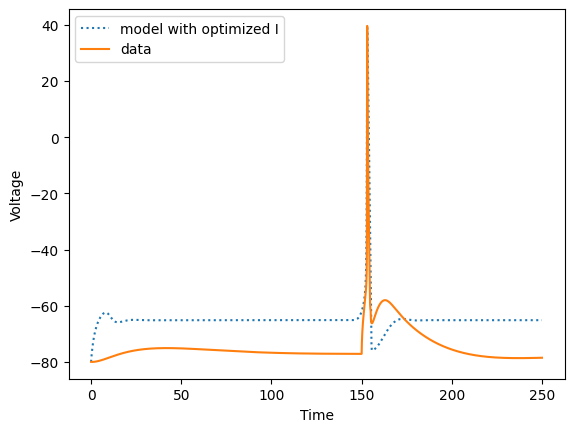

In [22]:
# compute V with optimal I
V_final = integrate_HH(V0, m, h, n, optim.x, dt, t)

plt.figure()
plt.plot(t, V_final, ls = 'dotted', label = 'model with optimized I')
plt.plot(data_steps, V_data, label = 'data')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()